# Inference: No-U-Turn (NUTS) MCMC

This example shows you how to perform Bayesian inference on a time-series problem, using [No-U-Turn Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/nuts_mcmc.html) (NUTS). NUTS is a variant on the original [Hamiltonian MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html), but features a number of adaptive features that aims to reduce the number of hyper-paramters to zero. Dual averaging is used to adapt the step size $\epsilon$ and mass matrix $M$. More importantly, the NUTS algorithm makes an optimal choice for the number of steps per iteration ($L$), which depends on the local position of the particle in parameter space. If the particle is in a relatively flat (low) region, then a higher $L$ is optimal to move away from this uninteresting area towards regions of higher density. If it is in a region with more curvature, choosing a high value for $L$ can be inefficient because the particle may start to re-explore parts of space already visited; it   may execute ``U-Turns''.                     

NUTS is the default sampler for packages such as [Stan](https://mc-stan.org/), [PyMC3](https://docs.pymc.io/) and [Pyro](http://pyro.ai/), so including this sampler in Pints is useful for comparison with these libraries. However, it must be noted that the exact implementation will differ slightly between each library, so care must be taken when interpreting results. Out goal with the Pints implementation was to reproduce the Stan version of NUTS as best we could.

First, we setup a problem using the logistic growth toy problem.

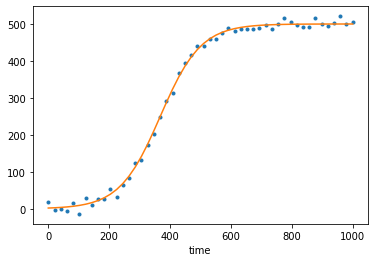

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.')
plt.plot(times, org_values)
plt.xlabel('time')
plt.show()

Now we set up and run a sampling routine using No-U-Turn MCMC. In the initialisation of the No-U-Turn algorithm the sampler tries to find a reasonable value for `epsilon`, the leapfrog step size, which results in many overflows seen from evaluating the logistic model.

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.


/home/mrobins/git/pints2/pints/toy/_logistic_model.py:76: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:83: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:83: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:85: RuntimeWarning: overflow encountered in square
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:85: RuntimeWarning: invalid value encountered in true_divide
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:83: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2


Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     3192   0.496    176     0.5      512     0.633    64       0:00.5
1     3204                    0.4      2                         0:00.5
2     3300                    0.485    16                        0:00.5
3     3327                    0.45     5                         0:00.5


/home/mrobins/git/pints2/pints/toy/_logistic_model.py:79: RuntimeWarning: overflow encountered in multiply
  values = k / (1 + c * exp)
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:84: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 1] = -k * exp / \
/home/mrobins/git/pints2/pints/toy/_logistic_model.py:85: RuntimeWarning: overflow encountered in multiply
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)


100   126969  0.793    426     0.84     53      0.786    198      0:20.8
200   179361  0.77     249     0.91     19      0.85     11       0:30.0
300   190402  0.777    110                                        0:31.9
400   197360  0.786    69                                         0:33.2
500   202265  0.775    49                                         0:34.1
600   207797  0.891    55                                         0:35.1
700   212357  0.879    46                                         0:35.9
800   216369  0.877    40                                         0:36.6
900   221287  0.867    49                                         0:37.5
1000  226549  0.877224 53                                         0:38.5
1100  232111  0.898    56                                         0:39.5
1200  237443  0.876    53                                         0:40.5
1300  242477  0.887    50                                         0:41.4
1400  247635  0.867    52                          

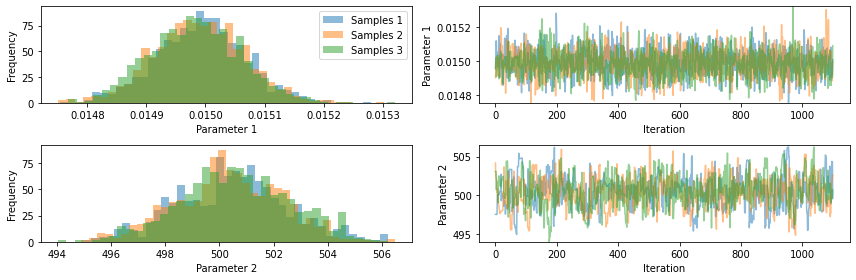

R-hat:
[1.0014611395392252, 1.0045424184040066]


In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(1500)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')

# Discard warm-up
nuts_chains = nuts_chains[:, 400:]

pints.plot.trace(nuts_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(nuts_chains))

We can do the same using Hamiltonian MCMC. Not that this implementation of HMC does not use dual-averaging for the step size, nor does it use an adaptive mass matrix like the NUTS implementation, so we expect HMC to be much less efficient than the tuned NUTS sampler.

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.971     0.971     0.98       0:00.7
200   12003  0.975     0.980198  0.990099   0:01.4
300   18003  0.98      0.986755  0.993      0:02.0
400   24003  0.983     0.985     0.995      0:02.7
500   30003  0.986     0.988     0.996      0:03.4
600   36003  0.986711  0.986711  0.993      0:04.1
700   42003  0.988604  0.988604  0.994302   0:04.7
800   48003  0.99      0.989     0.994      0:05.4
900   54003  0.991     0.99      0.993      0:06.1
1000  60003  0.989022  0.991018  0.994012   0:06.8
1100  66003  0.99      0.991833  0.995      0:07.4
1200  72003  0.991     0.993     0.995      0:08.1
1300  78003  0.992     0.993     0.995     

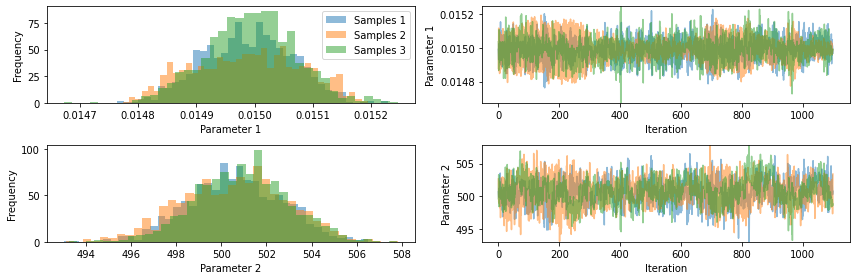

R-hat:
[1.0016799579469862, 1.0069853595188742]


In [3]:
# Create mcmc routine
h_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.HamiltonianMCMC)
h_mcmc.set_max_iterations(1500)

# Set up modest logging
h_mcmc.set_log_to_screen(True)
h_mcmc.set_log_interval(100)

# Run!
print('Running...')
h_chains = h_mcmc.run()
print('Done!')

# Discard warm up
h_chains = h_chains[:, 400:]

pints.plot.trace(h_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(h_chains))

Both samplers converge according to the R-hat measure, and both sets of chains are clearly mixing well and sampling the posterior correctly. However, the adaptive stepping in the NUTS sampler is resulting in an **order of magnitude** less function evaluations.

We can check the Estimated Sample Size (ESS) for both methods as well, which shows that NUTS also gives a slightly more consistent ESS across the two parameters.

In [4]:
# Check convergence using rhat criterion
print('NUTS Minimum ESS:')
print(np.min([pints.effective_sample_size(nuts_chains[i,:,:]) for i in range(nuts_chains.shape[0])],axis=0))
print('\nHamiltonian Minimum ESS:')
print(np.min([pints.effective_sample_size(h_chains[i,:,:]) for i in range(h_chains.shape[0])],axis=0))


NUTS Minimum ESS:
[269.20479477  96.96671531]

Hamiltonian Minimum ESS:
[366.66666667  47.98495251]
